# Let's try LDA on the training data and then transform test data in order to see if CNN is improved 

# Libraries for CNN

In [ ]:
import keras
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.callbacks import ModelCheckpoint 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import cv2


# Libraries for dimensional reduction 

In [2]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pylab as plt
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Load data 

In [3]:
with open("train.csv", 'r') as f:
    df_train = pd.read_csv(f)
    
with open("test.csv", 'r') as f:
    df_test = pd.read_csv(f)

In [4]:
df_train_label = df_train.iloc[:,0]
df_train_image = df_train.iloc[:,1:]

df_test_label = df_test.iloc[:,0]
df_test_image = df_test.iloc[:,1:]

In [40]:
#Standardize the data
from sklearn.preprocessing import StandardScaler
df_train_std = StandardScaler().fit_transform(df_train_image)

#Calculating Eigenvectors and eigenvalues of Cov matrix 
mean_vec = np.mean(df_train_std, axis=0)
cov_mat = np.cov(df_train_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
#Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [np.abs(eig_vals[i], eig_vecs[:,i]) for i in range(len(eig_vals))]

#sort the eigenvalues, eigenvector pair from high to low
eig_pairs.sort(key = lambda x: x[0], reverse = True)

#Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

In [57]:
#Visualization with Plotly
trace1 = go.Scatter(
    x=list(range(784)),
    y=cum_var_exp,
    mode='lines+markers',
    name="'Cumulative Explained Variance'",
    hoverinfo=cum_var_exp,
    line=dict(
        shape='spline',
        color='goldenrod'
        )
    )

trace2 = go.Scatter(
    x=list(range(784)),
    y=var_exp,
    mode='lines+markers',
    name="'Explained Variance'",
    hoverinfo=var_exp,
    line=dict(
        shape='linear',
        color='black'
        )
    )

fig = tls.make_subplots(insets=[{'cell': (1,1), 'l': 0.8, 'b': 0.5}],
                       print_grid=True)
    
    
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)
fig.layout.title = 'Explained Variance plots -Full and Zoomed-in'
fig.layout.xaxis = dict(range=[0,80], title = "Feature columns")
fig.layout.yaxis = dict(range=[0,60], title = "Explained variance")
fig['data'] += [go.Scatter(x=list(range(784)), y=var_exp, xaxis='x2', yaxis='y2', 
                           name='Individual Explained Variance')]
fig['data'] += [go.Scatter(x=list(range(784)), y=cum_var_exp, xaxis='x2', yaxis='y2',
                           name='Cumulative Explained Variance')]
py.iplot(fig, filename='inset example')

This is the format of your plot grid:
[ (1,1) x1,y1 ]

With insets:
[ x2,y2 ] over [ (1,1) x1,y1 ]

This is the format of your plot grid:
[ (1,1) x1,y1 ]

With insets:
[ x2,y2 ] over [ (1,1) x1,y1 ]



In [16]:
n_components = 228
pca = PCA(n_components, random_state=1337).fit(df_train_image.values)

eigenvalues = pca.components_

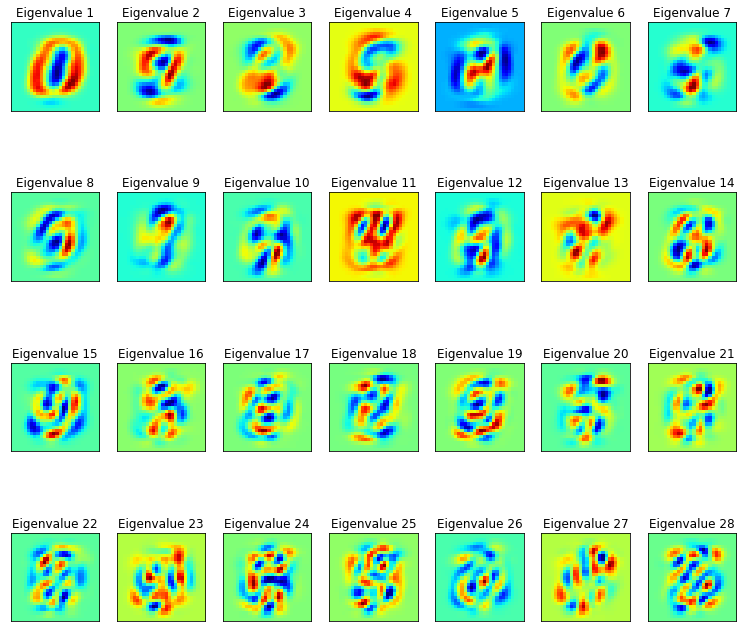

In [63]:
n_row = 4
n_col = 7

#plot first 8 eigenvalues
plt.figure(figsize=(13,12))
for i in list(range(n_row*n_col)):
    offset=0
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenvalues[i].reshape(28,28), cmap='jet')
    title_text = "Eigenvalue " + str(i+1)
    plt.title(title_text, size=12)
    plt.xticks(())
    plt.yticks(())
plt.show()

In [8]:
from sklearn.preprocessing import StandardScaler
X = df_train_image.values

X_std = StandardScaler().fit_transform(X)

pca = PCA(n_components=200).fit(X_std)
X_pca = pca.transform(X_std)

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning:

No labelled objects found. Use label='...' kwarg on individual plots.



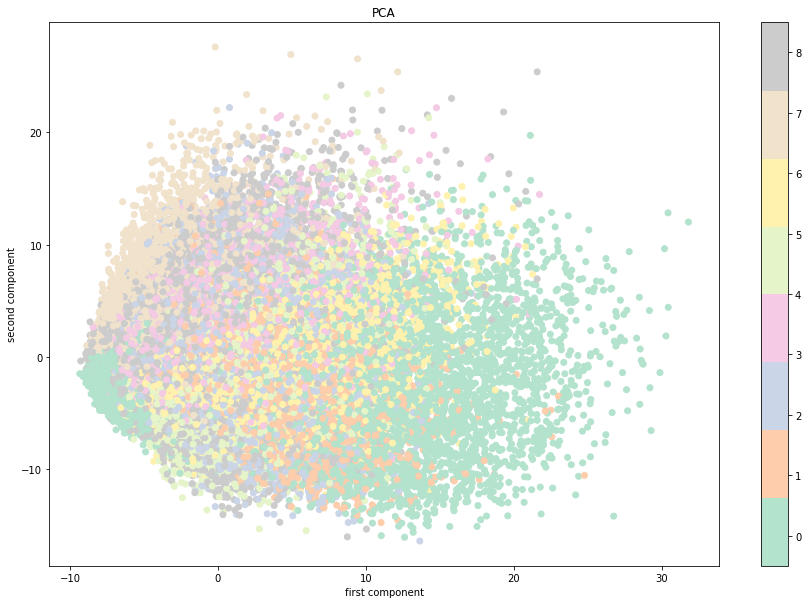

In [56]:
x = X_pca[:,0]
y = X_pca[:,1]
colors=df_train_label.values
plt.figure(figsize=(15,10))
plt.scatter(x=x,y=y,c=colors, cmap='Pastel2')
plt.legend()
plt.title("PCA")
plt.xlabel("first component")
plt.ylabel("second component")
cb=plt.colorbar(ticks=np.array(np.unique(colors))+0.5)
cb.set_ticklabels(np.unique(colors))

In [46]:
np.unique(colors)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [73]:
trace0 = go.Scatter(
    x=X_pca[:,0],
    y=X_pca[:,1],
    name=df_train_label,
    hoveron=df_train_label, 
    mode = 'markers',
    text=df_train_label,
    showlegend=False,
    marker=dict(
        size=8,
        color=df_train_label,
        colorscale='Jet',
        showscale=False,
        line = dict(
            width=2,
            color='rgb(255,255,255)'
            ),
        opacity = 0.8
        )
)

data=[trace0]

layout = go.Layout(
    title='PCA analysis',
    hovermode='closest',
    xaxis=dict(
        title="First principal component",
        ticklen=5,
        zeroline=False,
        gridwidth=2
        ),
    yaxis=dict(
        title="Second principal component",
        ticklen=5,
        gridwidth=2
        ),
    showlegend=True
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')
#py.plot(fig) <- saves file locally as .html

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


'file://C:\\Users\\Wignand\\Desktop\\python\\ML#\\MNIST\\temp-plot.html'

In [ ]:
trace0 = go.Scatter(
    x=X_pca[:2500,0],
    y=X_pca[:2500,1],
    name=df_train_label,
    hoveron=df_train_label, 
    mode = 'markers',
    text=df_train_label,
    showlegend=False,
    marker=dict(
        size=8,
        color=df_train_label,
        colorscale='Jet',
        showscale=False,
        line = dict(
            width=2,
            color='rgb(255,255,255)'
            ),
        opacity = 0.8
        )
)
data = [trace0]

layout = go.Layout(
    title= 'Principal Component Analysis (PCA)',
    hovermode= 'closest',
    xaxis= dict(
         title= 'First Principal Component',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Second Principal Component',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= True
)


fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

In [92]:
#Linear discriminant analysis - LDA

lda = LDA(n_components=n_components)
X_LDA_2D = lda.fit_transform(X_std, df_train_label)

C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning:

Variables are collinear.



In [ ]:
traceLDA = go.Scatter(
    x=X_LDA_2D[:5000,0],
    y=X_LDA_2D[:5000,1],
    name=df_train_label,
    mode='markers',
    text=df_train_label,
    showlegend=True,
    marker=dict(
        size=8,
        color=df_train_label,
        colorscale='Jet', 
        showscale=False,
        line = dict(
            width=1,
            color = 'rgb(255, 255, 255)'
        ),
        opacity=0.8
    )
)
data=[traceLDA]

layout = go.Layout(
    title="LDA",
    hovermode="closest",
    xaxis=dict(
        title="First Linear Discriminant",
        ticklen=5,
        zeroline=False,
        gridwidth=2
        ),
    yaxis=dict(
        title="Second Linear discriminant",
    ticklen=5,
    gridwidth=2
    ),
    showlegend=False
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename="LDA-scatter")
    

In [ ]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(X_std)

In [ ]:
traceTSNE = go.Scatter(
    x=tsne_results[:2500,0],
    y=tsne_results[:2500,0],
    name=df_target_label,
    hoveron=df_target_label,
    mode='markers',
    text=df_target_label,
    showlegend=True,
    marker = dict(
        size=8,
        color=df_target_label,
        colorscale='Jet',
        showscale=False,
        line = dict(
            width=1,
            color='rgb(255,255,255)'
            ),
        opacity=0.6
    )
)
data=[traceTSNE]

layout=go.Layout(
    title="TSNE",
    hovermode='closest',
    xaxis=dict(
        title="tsne1",
        ticklen=5,
        zeroline=False,
        gridwidth=2),
    yaxis=dict(
        title="tsne2",
        ticklen=5,
        gridwidth=2)
)

fig=dict(data=data, layout=layout)
py.iplot(fig, filename="tsne-scatter")

In [283]:
df_train_label = df_train_label.as_matrix()
df_train_image = df_train_image.as_matrix().reshape(df_train_image.shape[0], 28, 28, 1)

df_test_label = df_test_label.as_matrix()
df_test_image = df_test.as_matrix().reshape(df_test.shape[0], 28, 28, 1)

# Later tranform the images i.e. stretch and/or rotate a little bit 

# Visualize some random numbers from the datasets

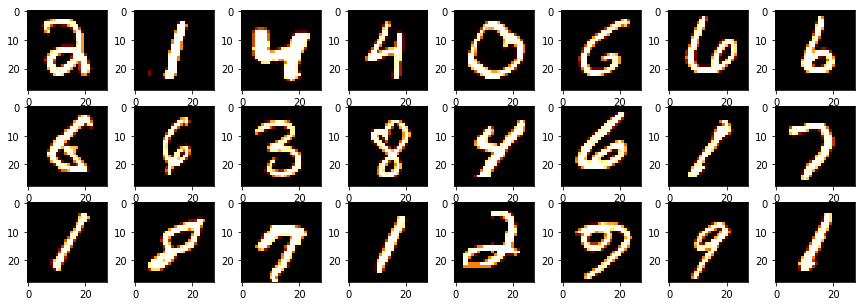

In [82]:
plt.figure(figsize = (15,5))
for i in range(24):
    plt.subplot(3,8,i+1)
    j = np.random.randint(0, len(df_train_image))
    plt.imshow(df_train_image[j].reshape(28,28), cmap='afmhot')

# Normalization
### Might be also changed to other normalization methods in order to see if it affects the prediction

In [284]:
# features normalisation
def normalize_grayscale(image_data):
    # Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    # you may also want to try to scale to [-1, 1] or just use keras Batchnormalisation layer
    return (image_data) / 255
train_features = normalize_grayscale(df_train_image)
test_features = normalize_grayscale(df_test_image)

In [285]:
#OneHotEncode labels
df_train_label = to_categorical(df_train_label)
df_test_label = to_categorical(df_test_label)

#Split dataset into train and validation 
X_train, X_val, y_train, y_val = train_test_split(train_features, df_train_label, test_size = 0.15, random_state=2)

#Print shape
print("Shape of validation set: {}".format(X_val.shape))
print("Shape of train set: {}".format(X_train.shape))
print("Shape of test set: {}".format(df_test_image.shape))
print(y_train.shape)

Shape of validation set: (6300, 28, 28, 1)
Shape of train set: (35700, 28, 28, 1)
Shape of test set: (28000, 28, 28, 1)
(35700, 10)


# Image augmentation

In [286]:
from keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(
    width_shift_range=0.12,
    height_shift_range=0.12,
    rotation_range=0.12,
    zoom_range = 0.11)

datagen_valid = ImageDataGenerator(
    width_shift_range=0.12,
    height_shift_range=0.12,
    rotation_range=10,
    zoom_range = 0.11)

datagen_train.fit(X_train)
datagen_valid.fit(X_val)

# Build the CNN

In [287]:
def get_model(input_shape):
    
    drop = 0.3
    
    X_input = Input(input_shape)
    
    X = Conv2D(64, (5,5), strides=(1,1), activation='relu', padding='same',
               kernel_initializer='glorot_normal')(X_input)
    
    X = Conv2D(64, (5,5), strides=(1,1), activation='relu', padding='same',
               kernel_initializer='glorot_normal')(X_input)
    
    X = MaxPooling2D(pool_size=(2,2))(X)
    
    X = Conv2D(128, (3,3), strides=(1,1), activation='relu', padding='same',
              kernel_initializer='glorot_normal')(X)
    
    X = Conv2D(128, (3,3), strides=(1,1), activation='relu', padding='same',
              kernel_initializer='glorot_normal')(X)
    
    X = MaxPooling2D(pool_size = (2,2))(X)
    
    X = Flatten()(X)
    
    X = Dense(256, activation='relu')(X)
    X = Dropout(drop)(X)
    
    X = Dense(32, activation='relu')(X)
    X = Dropout(drop)(X)
    
    X = Dense(10, activation='softmax')(X)
    
    model = Model(inputs=[X_input], outputs=[X])
    
    return model

In [288]:
from keras.optimizers import Nadam
#opt = Nadam(lr=0.001)
opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model

In [289]:
model = get_model((28, 28, 1))
# compile the model
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 6272)              0         
__________

# Train the model

In [290]:
# train the model
batch_size = 64
epochs = 15

checkpointer = ModelCheckpoint(filepath='model.weights.new.hdf5', verbose=1, 
                               save_best_only=True)
model.fit_generator(datagen_train.flow(X_train, y_train, batch_size), 
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=epochs, callbacks = [checkpointer],
                    validation_data=datagen_valid.flow(X_val, y_val,batch_size),
                    validation_steps=X_val.shape[0] // batch_size, 
                    verbose=2, shuffle=True)

Epoch 1/15
Epoch 00001: val_loss improved from inf to 0.16819, saving model to model.weights.new.hdf5
 - 401s - loss: 0.5979 - acc: 0.8112 - val_loss: 0.1682 - val_acc: 0.9530
Epoch 2/15
Epoch 00002: val_loss improved from 0.16819 to 0.13803, saving model to model.weights.new.hdf5
 - 420s - loss: 0.1976 - acc: 0.9483 - val_loss: 0.1380 - val_acc: 0.9636
Epoch 3/15
Epoch 00003: val_loss did not improve
 - 396s - loss: 0.1642 - acc: 0.9584 - val_loss: 0.1385 - val_acc: 0.9667
Epoch 4/15
Epoch 00004: val_loss did not improve
 - 389s - loss: 0.1516 - acc: 0.9631 - val_loss: 0.1398 - val_acc: 0.9646
Epoch 5/15
Epoch 00005: val_loss improved from 0.13803 to 0.12499, saving model to model.weights.new.hdf5
 - 391s - loss: 0.1622 - acc: 0.9633 - val_loss: 0.1250 - val_acc: 0.9640
Epoch 6/15
Epoch 00006: val_loss did not improve
 - 389s - loss: 0.1545 - acc: 0.9649 - val_loss: 0.1387 - val_acc: 0.9657
Epoch 7/15
Epoch 00007: val_loss improved from 0.12499 to 0.11334, saving model to model.weight

In [291]:
# load the weights that yielded the best validation accuracy
model.load_weights('model.weights.new.hdf5')

In [292]:
# evaluate and print test accuracy
pred = model.predict(test_features, batch_size=64, verbose=1)
pred_digits = np.argmax(pred, axis=1)

28000/28000 [==============================] - 95s 3ms/step


In [293]:
import datetime
today = str(datetime.datetime.now().strftime("%Y-%B-%d-%H-%M"))
submission = pd.DataFrame({'Label': pred_digits})
submission.index += 1
submission.index.name = "ImageId"
submission.to_csv('submission'+ today + '.csv')